***注:Assignement4包含1个代码填空和1个问答题， Assignment5包含2个代码填空和1个问答题**

## 决策树

在这一章节的Jupyter Notebook中，我们将会学习决策树的基本知识并实现ID3决策树模型，并使用实现的模型在Titanic数据集上根据每位乘客的不同特征对乘客进行二分类，用于分析乘客能否在灾难中存活。

### 关于决策树

决策树是一种常见的机器学习方法，在本章Notebook中，我们将会主要学习基于二分类任务的决策树模型。当基于给定的训练数据集时，决策树对样本的分类可以看做“当前样本属于正类吗？”这个问题进行决策的过程。

一般而言，一棵决策树包含一个根节点、若干个内部节点和若干个叶子节点，叶节点对应于决策结果，其他每个节点则对应一个属性测试；每个节点包含的样本集合根据属性测试的结果被划分到子节点中；根节点包含样本全集。决策树学习的目的是为了产生一棵泛化能力强的决策树。

当我们在创建一棵决策树时，我们一般遵循以下的递归过程：1）创建根节点，并将所有训练数据都放在根节点中；2）选择一个最优特征，按照这一特征将训练数据集分割成子集；3）如果这些子集已经能够将样本正确分类，那么构建叶节点并将子集放入对应叶节点；4）如果子集尚不能被正确分类，选择新的最优特征并递归以上的操作，直至所有的样本能被正确分类或没有合适的特征为止。

### ID3决策树与CART决策树

在介绍完决策树创建的基本流程之后，我们会很容易的发现，决策树最关键的地方在于如何选择最优特征，接下来我们将会介绍集中不同的决策树，并分析他们都是如何得到最优特征的。

信息熵（Information Entropy）可以反映样本中所包含信息量的平均值，假设样本集$D$中第$k$类样本所占比例为$p_k$，则样本集$D$的信息熵表达式如下所示，
$$
Entropy(D)=-\sum_{k=1}^{|y|}p_k\log_2p_k
$$
假设离散属性$a$有$V$个可能的取值$\{a^1,a^2,\dots,a^V\}$，若使用$a$来对样本集$D$进行划分，则会产生$V$个分支节点，其中第$v$个分支节点包含了$D$中所有在属性$a$上的取值为$a^V$的样本，记为$D^v$，考虑到不同的分支节点的样本数不同，我们为每个分支赋予权重$|D^v|/|D|$，即样本数越多的分支节点影响越大，最终可以计算出属性$a$对样本集$D$进行划分所获得的”信息增益“。
$$
Gain\_Entropy(D,a)=Entropy(D)-\sum_{v=1}^V\frac{|D^v|}{|D|}Entropy(D^v)
$$
著名的ID3决策树就是利用了信息熵增越大，使用属性$a$的划分效果越好的特性，使用信息熵增作为属性选择的准则。

与ID3决策树不同，CART决策树使用基尼指数（Gini Index）来选择划分属性，表达式如下：
$$
Gini(D)=\sum_{k=1}^{|y|}\sum_{j\neq k}p_kp_j = 1-\sum_{k=1}^{|y|}p_k^2
$$

$$
Gini\_Index(D,a)\sum_{v=1}^V\frac{|D^v|}{|D|}Gini(D^v) 
$$



基尼指数从样本集$D$中随机抽取两个样本，反映两个样本标签不一致的概率，相比之下，基尼指数不需要对数运算，更加高效，并更加适用于连续属性。


#### Question1 试证明用任意的属性a对样本集进行划分，得到的信息增益总是非负的

#### Answer: 
设原来的信息熵为$H(X)$, 在使用a进行划分后，信息增益为$I(X|Y) = H(X) - H(X|a)$, 又由信息论知识得，条件熵不会增大原信息量，因此 $H(X) \geq H(X|a)$， 因此$I(X|Y) \geq 0$，因此信息增益总是非负的

## 数据集

在本章节我们将会使用Titanic生存预测数据集，这是一个Kaggle上的公开数据集，对于每位乘客，数据集提供了包含仓位、姓名、性别、年龄等十个特征供我们给数据集进行分类，特征格式包含纯数值、字符串、文本等，下列表格提供了数据集样本的相关信息。

| Index | Variable   | Definition                                                   | Type |
| ----- | ---------- | ------------------------------------------------------------ | ---- |
| 0     | 'Pclass'   | Passenger's class (1st, 2nd, or 3rd)                         | cat  |
| 1     | 'Name'     | Passenger's name                                             | text |
| 2     | 'Sex'      | Passenger's sex                                              | cat  |
| 3     | 'Age'      | Passenger's age                                              | num  |
| 4     | 'SibSp'    | Number of siblings/spouses aboard the Titanic                | cat  |
| 5     | 'Parch'    | Number of parents/children aboard the Titanic                | cat  |
| 6     | 'Ticket'   | Ticket number                                                | text |
| 7     | 'Fare'     | Fare paid for ticket                                         | num  |
| 8     | 'Cabin'    | Cabin number                                                 | set  |
| 9     | 'Embarked' | Where the passenger got on the ship (C - Cherbourg, S - Southampton, Q = Queenstown) | cat  |


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

## 数据集预处理

数据集预处理部分，我们将会将特征分为文本特征和数值特征，首先我们将读入文件并按行处理数据集输入，按引号位置将行切分为特征值并储存成list形式。


In [15]:
CAT_FEAT = [0, 2, 4, 5, 9]
NUM_FEAT = [3, 7]

# 按行处理输入样本，并根据引号将行划分为特征值，存储为list
def parse_feat(line):
    quota = False
    j = 0
    feats = []
    for i in range(len(line)):
        if line[i] == '\"':
            quota = not quota
        if line[i] == ',' and not quota:
            feat = line[j:i]
            feats.append(feat)
            j = i+1
    return feats + [line[j:]]


# 载入数据集的CSV文件并用刚刚实现的处理函数处理数据
def load_file(file_name):
    data = []
    with open(file_name, 'r') as fin:
        print('field_names:', fin.readline().strip().split(','))
        for line in fin:
            line = line.strip()
            data.append(parse_feat(line))
    return np.array(data)

train_data = load_file('./dataset/Assignment4/titanic/train.csv')
test_data = load_file('./dataset/Assignment4/titanic/test.csv')

train_id, train_label, train_feat = train_data[:, 0], train_data[:, 1], train_data[:, 2:]
test_id, test_feat = test_data[:, 0], test_data[:, 1:]

# 将数据集输出以便于了解数据集格式
print('训练样本特征:\n', train_feat[0])
print('测试样本特征:\n', test_feat[0])

# 将文本特征的特征值设置为None
train_feat[:, [1, 6, 8]] = None
test_feat[:, [1, 6, 8]] = None

print('训练样本特征:\n', train_feat[0])
print('测试样本特征:\n', test_feat[0])

field_names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
field_names: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
训练样本特征:
 ['3' '"Braund, Mr. Owen Harris"' 'male' '22' '1' '0' 'A/5 21171' '7.25' ''
 'S']
测试样本特征:
 ['3' '"Kelly, Mr. James"' 'male' '34.5' '0' '0' '330911' '7.8292' '' 'Q']
训练样本特征:
 ['3' 'None' 'male' '22' '1' '0' 'None' '7.25' 'None' 'S']
测试样本特征:
 ['3' 'None' 'male' '34.5' '0' '0' 'None' '7.8292' 'None' 'Q']


[ 0.17   8.153 16.136 24.119 32.102 40.085 48.068 56.051 64.034 72.017]


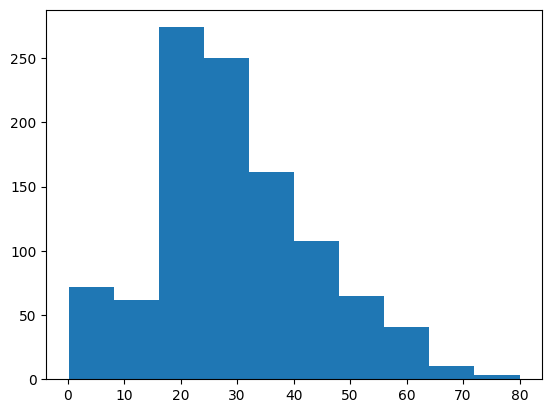

[  0.       51.23292 102.46584 153.69876 204.93168 256.1646  307.39752
 358.63044 409.86336 461.09628]


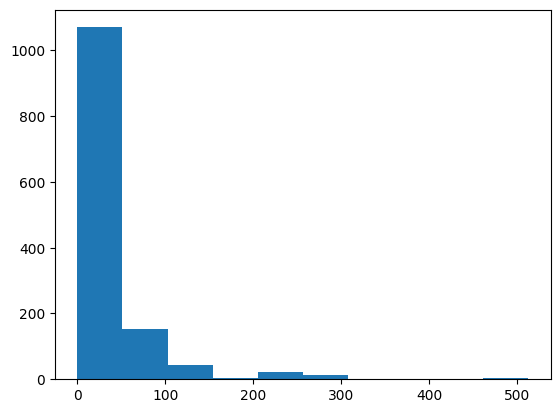

In [16]:
def num2cat(num_feat, n_class=10):
	# 将数值转换为浮点数的内建函数
    def to_float(x):
        if len(x):
            return float(x)
        else:
            return -1

    num_feat = np.array([to_float(x) for x in num_feat])
    min_val, max_val = num_feat[num_feat > -1].min(), num_feat.max()
    # 使用linspace函数将函数取值分割为n_class个类别，这里我们默认将n_class设置为10
    sep = np.linspace(min_val, max_val, n_class, endpoint=False)
    print(sep)
    plt.hist(num_feat[num_feat > -1], bins=n_class) 
    plt.show()

    def indicator(x):
        x = to_float(x)
        if x == -1:
            return 0
        for i in range(len(sep)):
            if x < sep[i]:
                return i    
        return n_class

    return indicator

# 使用上述实现的函数完成数据离散化的过程，并可视化数据集离散化之后样本点的分布情况
for nf in NUM_FEAT:
    ind = num2cat(list(train_feat[:, nf]) + list(test_feat[:, nf]))
    for _ in range(len(train_feat[:, nf])):
        train_feat[_, nf] = str(ind(train_feat[_, nf]))
    for _ in range(len(test_feat[:, nf])):
        test_feat[_, nf] = str(ind(test_feat[_, nf]))

In [17]:
train_feat = np.delete(train_feat, [1, 6, 8], axis=1)
test_feat = np.delete(test_feat, [1, 6, 8], axis=1)

print('train_feat:\n', train_feat)
print('test_feat:\n', test_feat)

train_feat:
 [['3' 'male' '3' ... '0' '1' 'S']
 ['1' 'female' '5' ... '0' '2' 'C']
 ['3' 'female' '4' ... '0' '1' 'S']
 ...
 ['3' 'female' '0' ... '2' '1' 'S']
 ['1' 'male' '4' ... '0' '1' 'C']
 ['3' 'male' '4' ... '0' '1' 'Q']]
test_feat:
 [['3' 'male' '5' ... '0' '1' 'Q']
 ['3' 'female' '6' ... '0' '1' 'S']
 ['2' 'male' '8' ... '0' '1' 'Q']
 ...
 ['3' 'male' '5' ... '0' '1' 'S']
 ['3' 'male' '0' ... '0' '1' 'S']
 ['3' 'male' '0' ... '1' '1' 'C']]


## 定义Dataset类

在这里我们将定义Dataset类，并定义内建函数来更好的处理数据集，我们将会把各个特征转换为one-hot编码的格式以方便之后的计算，我们还会将样本集中20%的数据作为测试集，其余的用于训练集。


In [18]:
class Dataset:
    # 将数据的特征转换为one-hot编码
    @staticmethod
    def build_feat_map(cat_feats):
        feat_map = {}
        for i in range(cat_feats.shape[1]):
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                if feat_name not in feat_map:
                    feat_map[feat_name] = len(feat_map)

        return feat_map
    
    def feat2id(self, cat_feats):
        feat_ids = []
        for i in range(cat_feats.shape[1]):
            feat_ids.append([])
            for x in cat_feats[:, i]:
                feat_name = str(i) + ':' + x
                feat_ids[-1].append(self.feat_map[feat_name])
        return np.int32(feat_ids).transpose()
    
    # 将20%的样本作为测试集，其余的作为训练集
    def split_train_valid(self):
        np.random.seed(123)
        rnd = np.random.random(len(self.train_label))
        self.train_ind = np.where(rnd < 0.8)[0]
        self.valid_ind = np.where(rnd >= 0.8)[0]

        def to_csr(data, dim=len(self.feat_map)):
            row = np.zeros_like(data) + np.expand_dims(np.arange(len(data)), 1)
            val = np.ones_like(data)
            return csr_matrix((val.flatten(), (row.flatten(), data.flatten())), shape=(len(data), dim))    
            
        self.train_data = (self.train_label[self.train_ind], to_csr(self.train_feat[self.train_ind]))
        self.valid_data = (self.train_label[self.valid_ind], to_csr(self.train_feat[self.valid_ind]))
        self.test_data = (np.zeros(len(self.test_feat), dtype=np.int32), to_csr(self.test_feat))
    
    def __init__(self):
        self.feat_map = self.build_feat_map(np.vstack([train_feat, test_feat]))

        self.train_id, self.test_id = train_id, test_id
        self.train_label = np.int32(train_label)
        self.train_feat, self.test_feat = self.feat2id(train_feat), self.feat2id(test_feat)

        print('train_feat:\n', self.train_feat)
        print('test_feat:\n', self.test_feat)

        self.split_train_valid()
        
Data = Dataset()

train_feat:
 [[ 0  3  5 ... 23 31 39]
 [ 1  4  6 ... 23 32 40]
 [ 0  4  7 ... 23 31 39]
 ...
 [ 0  4  8 ... 25 31 39]
 [ 1  3  7 ... 23 31 40]
 [ 0  3  7 ... 23 31 41]]
test_feat:
 [[ 0  3  6 ... 23 31 41]
 [ 0  4 14 ... 23 31 39]
 [ 2  3 12 ... 23 31 41]
 ...
 [ 0  3  6 ... 23 31 39]
 [ 0  3  8 ... 23 31 39]
 [ 0  3  8 ... 24 31 40]]


In [19]:
train_label, train_feat = Data.train_data[0], Data.train_data[1].toarray()
valid_label, valid_feat = Data.valid_data[0], Data.valid_data[1].toarray()

print('train_feat:\n', train_feat)
print('valid_feat:\n', valid_feat)

train_feat:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 1 0]]
valid_feat:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


## 实现ID3决策树

之前我们已经介绍了决策树的知识内容与ID3决策树、CART决策树，在这里我们将动手实现ID3决策树现在我们来回忆一下ID3决策树的信息增益公式。
$$
Entropy(D)=-\sum_{k=1}^{|y|}p_k\log_2p_k
$$

$$
Gain\_Entropy(D,a)=Entropy(D)-\sum_{v=1}^V\frac{|D^v|}{|D|}Entropy(D^v)
$$

在实现完ID3决策树之后，我们将决策树使用在已经准备好的数据集上，并统计决策树预测的准确率。


In [20]:
NID = {}
import math
class Node:
    def __init__(self, feat_id=-1):
        self.feat_id = feat_id
        self.nid = len(NID)
        NID[self.nid] = self
        self.t_child = None
        self.f_child = None
        self._class = -1
        

class DecisionTree:
    def __init__(self, n_feat, max_depth=6, verbose=True):
        self.n_feat = n_feat
        self.max_depth = max_depth
        self.verbose = verbose
        self.root_node = Node()

    @staticmethod
    def entropy(labels):
        #############################################################################
        # TODO:                                                                     #
        # Calculate the entropy                                                   #
        #############################################################################
        p = labels.sum() / len(labels)
        if p == 0 or p == 1:
            return 0
        return - p * math.log(p) - (1 - p) * math.log(1 - p)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def fit(self, labels, data, cur_node=None, cur_depth=1):
        if cur_node is None:
            cur_node = self.root_node

        if self.verbose:
            print(cur_node.nid)
        
        if labels.sum() == len(labels):
            # 所有instance的label都为1
            cur_node._class = 1
            cur_node.t_child = None
            cur_node.f_child = None
            return
        elif labels.sum() == 0:
            # 所有instance的label都为0
            cur_node._class = 0
            cur_node.t_child = None
            cur_node.f_child = None
            return
        elif cur_depth == self.max_depth:
            cur_node._class = labels.sum() / len(labels) >= 0.5
            cur_node.t_child = None
            cur_node.f_child = None
            return
        
        base_ent = self.entropy(labels)
        info_gain = 0
        best_split = None
        best_t_ind = None
        best_f_ind = None
        
        csc_data = data.tocsc()
        for f in range(self.n_feat):
            feat = csc_data[:, f].toarray().flatten()
            t_ind = feat == 1
            f_ind = feat == 0
            f_ent = base_ent
            if t_ind.sum():
                f_ent -= t_ind.sum() / len(feat) * self.entropy(labels[t_ind])
            if f_ind.sum():
                f_ent -= f_ind.sum() / len(feat) * self.entropy(labels[f_ind])
            if info_gain < f_ent:
                info_gain = f_ent
                best_split = f
                best_t_ind = t_ind
                best_f_ind = f_ind
                
        if info_gain == 0:
            cur_node._class = labels.sum() / len(labels) >= 0.5
            cur_node.t_child = None
            cur_node.f_child = None
            return
                
        cur_node.feat_id = best_split
        cur_node.t_child = Node()
        cur_node.f_child = Node()
        
        self.fit(labels[best_t_ind], data[best_t_ind], cur_node.t_child, cur_depth+1)
        self.fit(labels[best_f_ind], data[best_f_ind], cur_node.f_child, cur_depth+1)

    def predict(self, data):
        assert data.ndim == 1
        cur_node = self.root_node
        feat_set = set(data)

        while True:
            if cur_node.t_child is None or cur_node.f_child is None:
                return cur_node._class
            if cur_node.feat_id in feat_set:
                cur_node = cur_node.t_child
            else:
                cur_node = cur_node.f_child

    def batch_predict(self, data):
        preds = []
        for i in range(data.shape[0]):
            preds.append(self.predict(data[i].tocoo().col))
        return np.array(preds)

    def acc(self, labels, data):
        preds = self.batch_predict(data)
        acc = np.int32(labels == preds).sum() / len(labels)
        return acc

DT = DecisionTree(len(Data.feat_map), max_depth=10, verbose=False)   #超参调节max_depth
DT.fit(*Data.train_data)

print('train acc:',DT.acc(*Data.train_data))
print('valid acc:',DT.acc(*Data.valid_data))

train acc: 0.8712871287128713
valid acc: 0.8097826086956522


## 使用sklearn实现决策树

在这一部分中，我们将使用sklearn中封装好的DecisionTreeClassifier来实现决策树，并在Titanic数据集上进行拟合。可以发现最终sklearn的结果会稍微优于我们实现的版本。

In [21]:
from sklearn import tree

train_label, train_feat = Data.train_data[0], Data.train_data[1].toarray()
valid_label, valid_feat = Data.valid_data[0], Data.valid_data[1].toarray()

print('train_feat:\n', train_feat)
print('valid_feat:\n', valid_feat)

train_feat:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 1 0]]
valid_feat:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [22]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
clf.fit(train_feat, train_label)

train_preds = clf.predict(train_feat)
valid_preds = clf.predict(valid_feat)
print('train acc:', np.sum(train_preds == train_label) / len(train_label))
print('valid acc:', np.sum(valid_preds == valid_label) / len(valid_label))

train acc: 0.8769448373408769
valid acc: 0.8043478260869565


## 决策树的可视化

最后我们可以将训练得到的决策树做可视化，以便于我们观察决策树创建过程中使用了哪些feature。一份样例图像已上传至小作业/tree_view.png，或者你可以使用下方模块生成。

**注意：**下方模块需要使用sklearn0.21或以上的plot_tree支持方可运行，如需使用请自行更新版本。

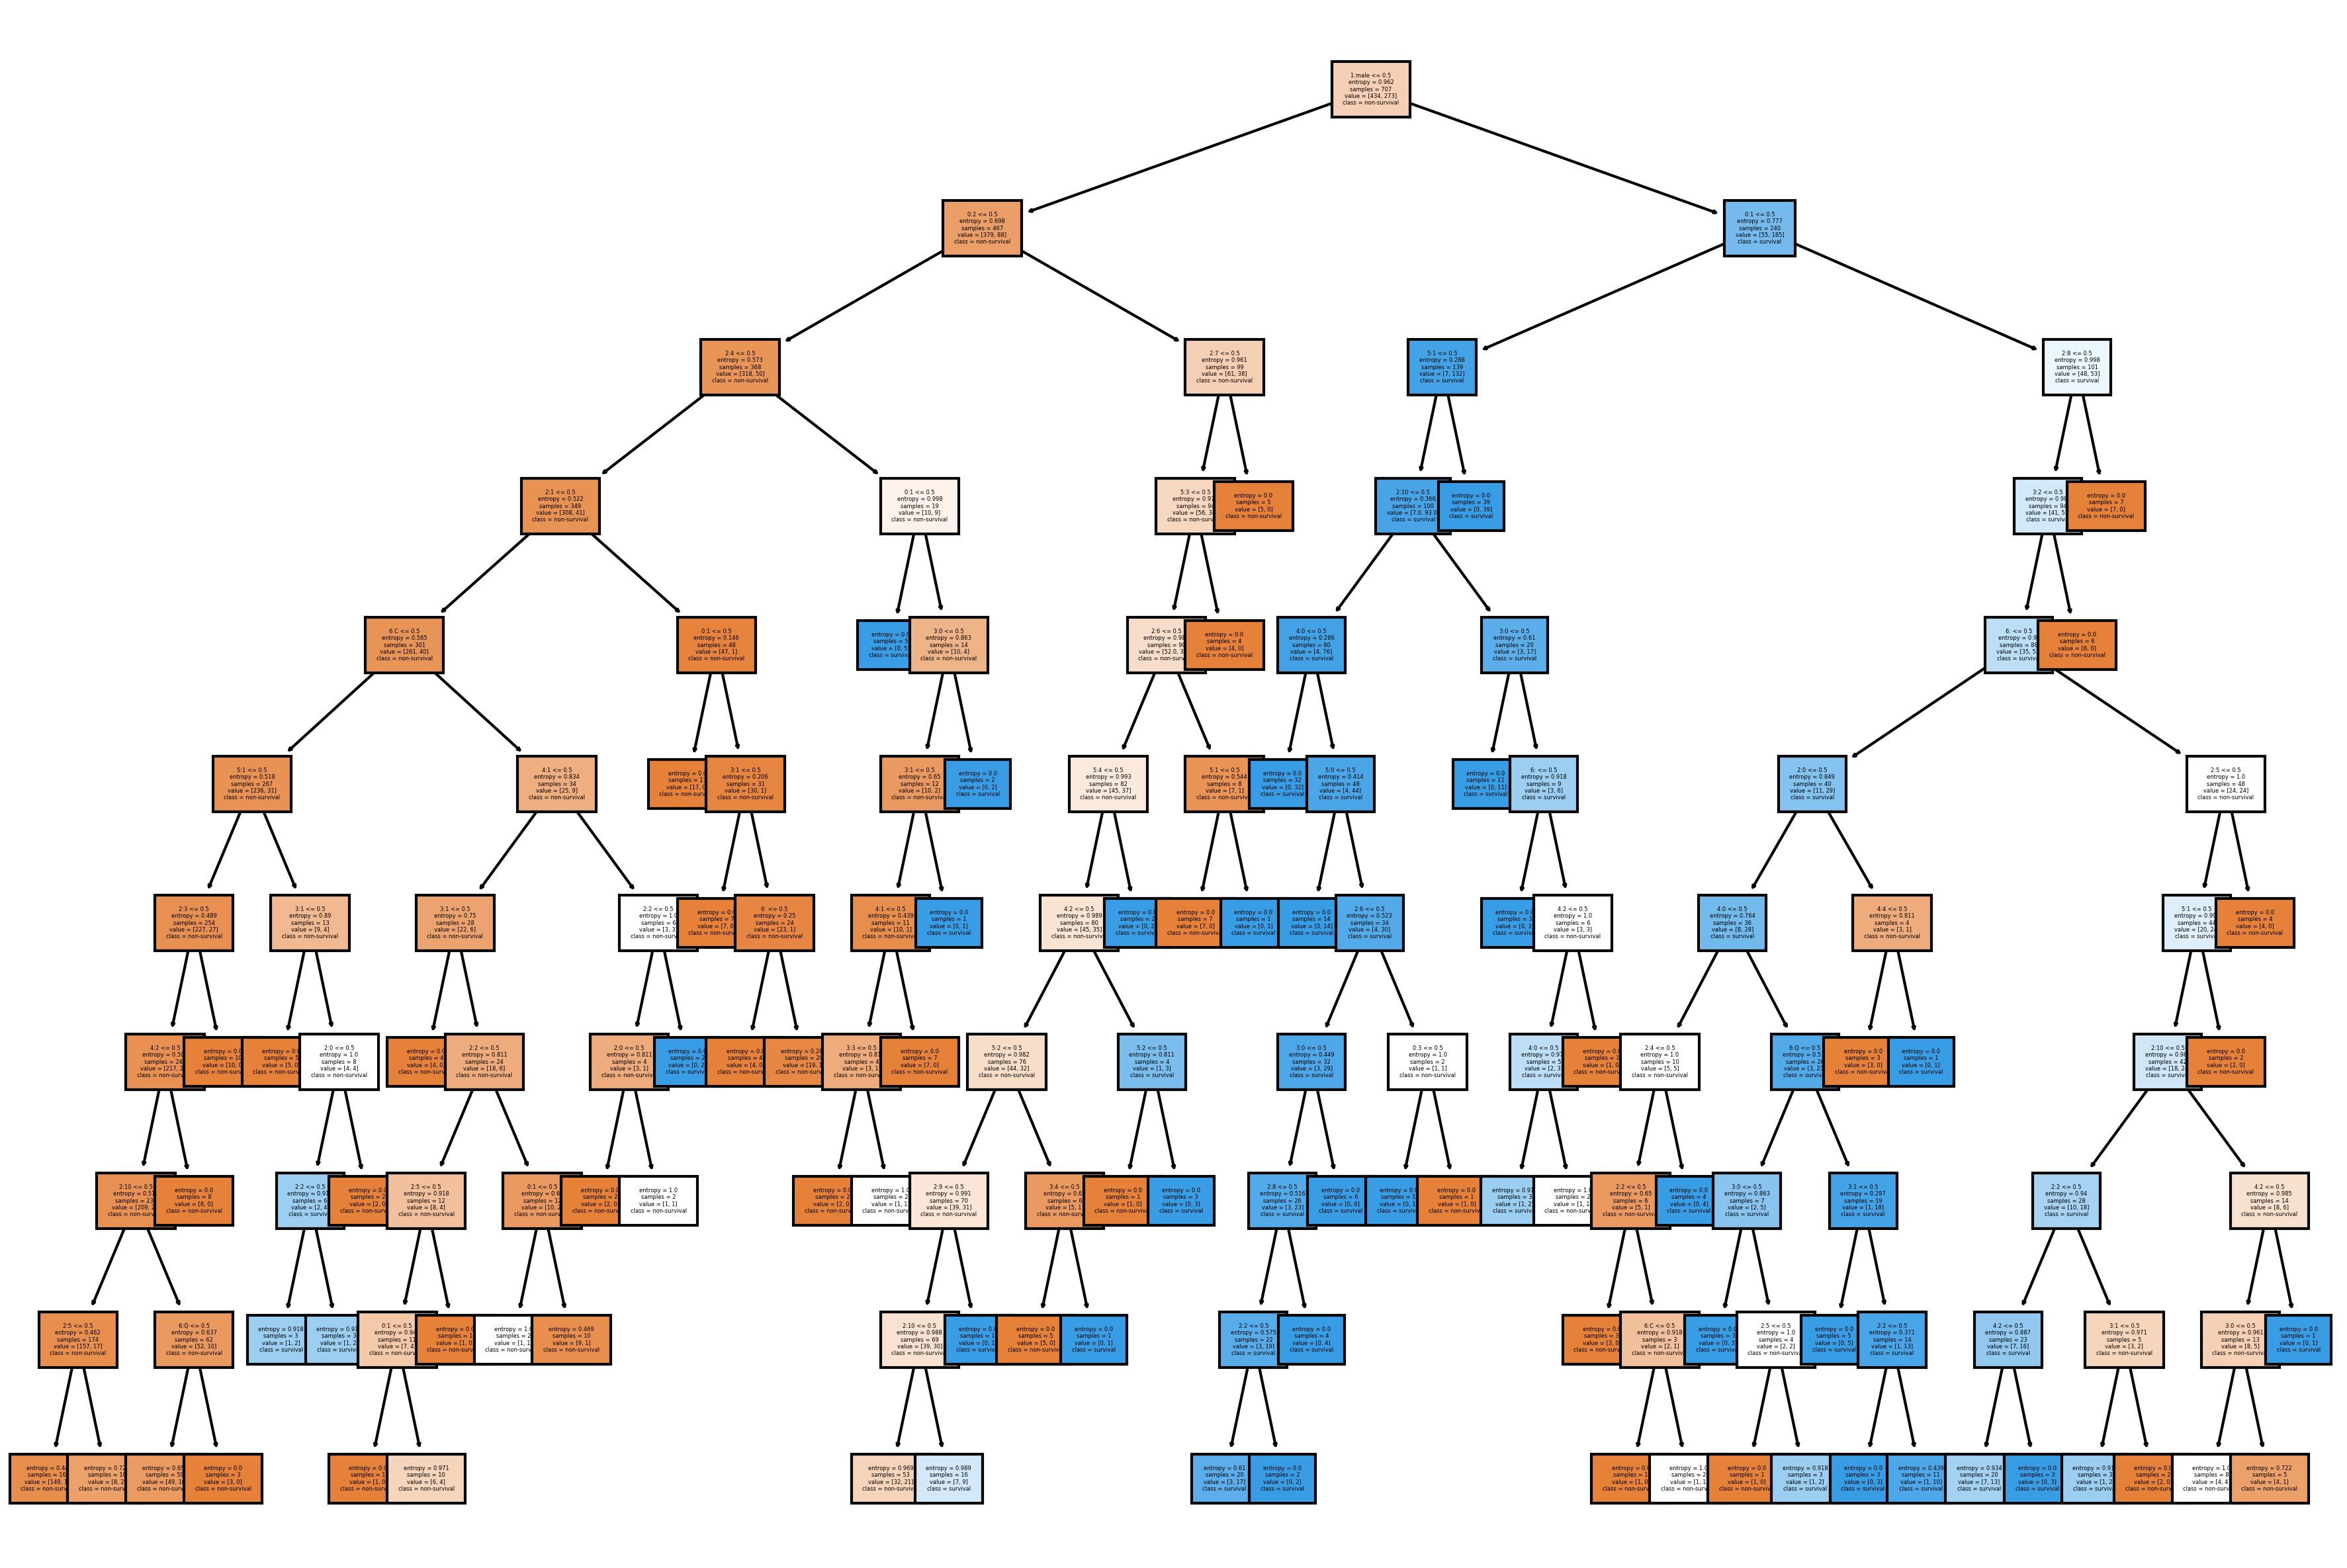

In [24]:
from six import StringIO
from sklearn import tree

fig =plt.figure(figsize=(15, 10),dpi=300)
tree.plot_tree(clf,
               feature_names=sorted(sorted(Data.feat_map.keys())),
               class_names=['non-survival', 'survival'],
               filled=True,
               fontsize=2)
plt.show()
fig.savefig('tree_view.png',dpi=300)
